<a href="https://colab.research.google.com/github/amkayhani/DSML24/blob/main/warwick_ai_chatbot_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🤖 Building a RAG-based Chatbot with LLMs
This Colab notebook demonstrates how to build a chatbot using a **Large Language Model (LLM)** and **Retrieval-Augmented Generation (RAG)**. The chatbot answers questions about the MSc Applied Artificial Intelligence programme at the University of Warwick.

## 🔍 What is an LLM?
**Large Language Models (LLMs)** are AI systems trained on massive text datasets to understand and generate human-like language. Examples include OpenAI's GPT models and Meta's **LLaMA** (Large Language Model Meta AI). In this notebook, we use we use a the **LLaMA3-8b** for demonstration purposes.

## 🧠 What is RAG (Retrieval-Augmented Generation)?
**Retrieval-Augmented Generation** enhances LLM responses by incorporating external knowledge. Instead of relying only on pre-trained information, RAG retrieves relevant documents from a database and feeds them into the LLM, making the chatbot more accurate and grounded in up-to-date information.

## 📦 Step 1: Install Required Libraries
We begin by installing the libraries needed for language processing, scraping, vector storage, and the chatbot UI.

In [ ]:
# Install required libraries
!pip install -q langchain chromadb gradio bs4 requests
!pip install -U langchain-community
!pip -q install -U langchain langchain-core langchain-community langchain-text-splitters
import shutil, os
if os.path.exists("./chroma_db"):
    shutil.rmtree("./chroma_db")



## 🌐 Step 2: Web Scraping the Programme Page
We use `requests` and `BeautifulSoup` to download and parse the MSc. Applied AI programme page at the University of Warwick website.

In [ ]:
# Web Scraping the programme page
from bs4 import BeautifulSoup  # Parse HTML using BeautifulSoup
import requests

#You can substitute this URL with another webpage's URL
url = "https://warwick.ac.uk/fac/sci/wmg/study/masters-degrees/applied-artificial-intelligence"
response = requests.get(url)  # Fetch the HTML content of the target web page
soup = BeautifulSoup(response.text, 'html.parser')  # Parse HTML using BeautifulSoup

# Add tags like 'span', 'div', 'td' (table cells), 'th', 'a', 'blockquote', etc.
tags = ['p', 'h1', 'h2', 'h3', 'strong', 'li', 'span', 'div', 'td', 'th', 'blockquote']
all_text_nodes = soup.find_all(tags)

# Join their text, preserving a single space between elements
text = ' '.join([tag.get_text(separator=' ', strip=True) for tag in all_text_nodes])

## ✂️ Step 3: Split the Text into Chunks
To make the data manageable, we split the scraped text into smaller chunks using LangChain's `RecursiveCharacterTextSplitter`.

In [ ]:
# Split text into chunks
#from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_text_splitters import RecursiveCharacterTextSplitter


text_splitter = RecursiveCharacterTextSplitter(chunk_size=900, chunk_overlap=300)  # Splits long text into overlapping chunks
#texts = text_splitter.create_documents([text])


#text_splitter = RecursiveCharacterTextSplitter(
#    chunk_size=1200,
#    chunk_overlap=150,
#    separators=["\n\n", "\n", "•", "*", ". ", " ", ""],
#)
texts = text_splitter.create_documents([text])


## 🧬 Step 4: Create Embeddings and Store in ChromaDB
We generate vector embeddings of each text chunk and store them in a vector database (Chroma) for fast retrieval.
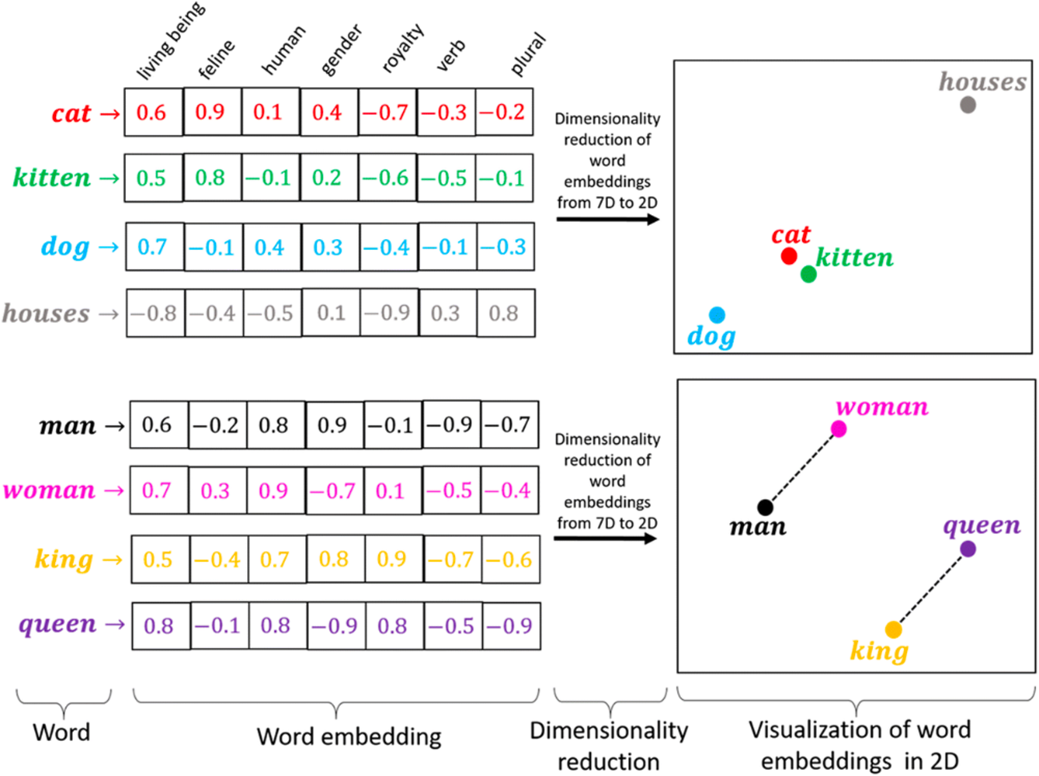

In [ ]:
# Create embeddings and store in ChromaDB

# If you haven't installed these yet in the notebook, run:
!pip -q install -U langchain-huggingface langchain-chroma chromadb sentence-transformers

from langchain_huggingface import HuggingFaceEmbeddings
from langchain_chroma import Chroma

# Use the full sentence-transformers name (recommended)
embedding_model = HuggingFaceEmbeddings(
    model_name="sentence-transformers/all-MiniLM-L6-v2"
)

# Create or connect to a local vector store
vectorstore = Chroma.from_documents(
    documents=texts,
    embedding=embedding_model,
    persist_directory="./chroma_db",   # optional, but useful to persist in the Colab VM
)



## 🧠 Step 5: Load and Configure the LLM with RAG
In this step, we configure the Large Language Model (LLM) and integrate it with our retriever using LangChain’s RetrievalQA chain to enable RAG-based question answering.

In [ ]:
from langchain_huggingface import HuggingFacePipeline
from langchain_core.prompts import PromptTemplate
from langchain_classic.chains.retrieval import create_retrieval_chain
from langchain_classic.chains.combine_documents import create_stuff_documents_chain

from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline

model_name = "meta-llama/Meta-Llama-3-8B-Instruct"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name, device_map="auto", torch_dtype="auto")

# Helps with some LLaMA tokenisers that don't define pad token
if tokenizer.pad_token_id is None:
    tokenizer.pad_token_id = tokenizer.eos_token_id

pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=256,
    temperature=0.3,
    repetition_penalty=1.1,
    return_full_text=False,          # ✅ key line: don't echo prompt/context back
    pad_token_id=tokenizer.eos_token_id,
)

from langchain_huggingface import HuggingFacePipeline
llm = HuggingFacePipeline(pipeline=pipe)


prompt = PromptTemplate(
    input_variables=["context", "input"],
    template=(
        "You are a helpful AI assistant. Use you knowledge and the information in the context below to answer the question.\n"
        "If the question asks for a list (e.g. modules), extract ALL items that match, and present them as bullet points.\n"
        "Do NOT say 'these are the only ones' unless the context explicitly says the list is complete.\n"
        "If you are not able to provide an accurate answer, say "
        "\"Unfortunately, I can't answer this question. Please contact the course leader for further information.\".\n\n"
        "Context:\n{context}\n\n"
        "Question:\n{input}\n\n"
        "Answer:\n"
    ),
)

#retriever = vectorstore.as_retriever(search_kwargs={"k": 7})
retriever = vectorstore.as_retriever(
    search_type="mmr",
    search_kwargs={"k": 14, "fetch_k": 50, "lambda_mult": 0.3},
)



doc_chain = create_stuff_documents_chain(llm, prompt)
qa_chain = create_retrieval_chain(retriever, doc_chain)

## 💬 Step 6: Build a Gradio Interface
Finally, we create a simple user interface using Gradio to interact with the chatbot.

In [ ]:
# Create Gradio interface
import gradio as gr

synonym_map = {
    "course leader": ["course director", "programme leader", "programme director"],
    #"modules": ["subjects", "courses", "units"],
    "lecturer": ["instructor", "tutor", "teaching staff"],
    "assessment": ["exams", "tests", "evaluation"],
    "dissertation": ["thesis", "final project", "research project"],
}

def expand_question_with_synonyms(question: str):
    # Return a list of alternative queries (better than OR-ing a single string for vector search)
    q = question.strip()
    expanded = [q]
    q_lower = q.lower()

    for key, synonyms in synonym_map.items():
        if key in q_lower:
            for alt in synonyms:
                expanded.append(q_lower.replace(key, alt))

    # de-dupe while preserving order
    seen = set()
    out = []
    for item in expanded:
        if item not in seen:
            out.append(item)
            seen.add(item)
    return out

def answer_question(user_input: str):
    try:
        queries = expand_question_with_synonyms(user_input)

        # Try the original + synonym variants; return the first decent answer
        for q in queries:
            result = qa_chain.invoke({"input": q})  # <-- key change (no .run)
            if isinstance(result, dict):
                answer = result.get("answer", "").strip()
            else:
                answer = str(result).strip()

            if answer:
                return answer

        return "Unfortunately, I can't answer this question. Please contact the course leader for further information."

    except Exception as e:
        # Show a concise error in the UI (so you can debug quickly)
        return f"Error: {type(e).__name__}: {e}"

interface = gr.Interface(
    fn=answer_question,
    inputs="text",
    outputs="text",
    title="Warwick MSc Applied AI Chatbot",
    description="Ask questions about the MSc Applied Artificial Intelligence programme at the University of Warwick."
)

interface.queue()
interface.launch(debug=True)


In [ ]:
needle = "Programming for Artificial Intelligence"
hits = vectorstore.similarity_search(needle, k=10)

print("Found?", any(needle in d.page_content for d in hits))
for d in hits[:3]:
    print("\n---\n", d.page_content[:600])


In [ ]:
retriever_modules = vectorstore.as_retriever(
    search_type="similarity",
    search_kwargs={"k": 12},
)

docs = retriever_modules.invoke("core modules (15 credits) list")
for i, d in enumerate(docs[:5], 1):
    print(f"\n--- DOC {i} ---\n{d.page_content[:800]}")


##🧠 Exercise Activities
**✍️ Exercise 1:** Customise the Prompt Template
Modify the PromptTemplate used in the chatbot to change the assistant's tone. For example:

Make it more conversational, friendly or formal.


**✍️ Exercise 2:** Extend the Knowledge Base
Replace or extend the source content (currently scraped from one Warwick MSc page) by:

* Scraping an additional page (e.g. another MSc or the student handbook)

* Merging its content into the same vectorstore



**✍️ Exercise 3:** Evaluate Retrieval Quality
The retriever currently uses k=7: retriever=vectorstore.as_retriever(search_kwargs={"k": 7})

Try different values for k (e.g. 3, 10, 15).
How does changing k affect:

* Response accuracy?

* Irrelevant information?

Record a few queries and compare outputs.

##✍️ Exercise 4: Swap the Language and Embedding Models
* Change the Embeddint model and Language model to antoher model(e.g. Mistral, etc.)
* Compare the answers

##✍️ Exercise 5: Enable Session Context
Right now, the chatbot treats each question independently.

* Implement a basic memory buffer using LangChain’s ConversationBufferMemory and integrate it into the chain.


